In [1]:
import torch
import torchaudio
import torchaudio.transforms as T

from config_creator import get_config
from torch import nn
from utils.audio import get_signal_mono

C:\Users\Luis\miniconda3\envs\audigest\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
config = get_config()
test_tensor = torch.rand(64, 128, 31)
print(test_tensor.shape)
test_tensor = test_tensor.unsqueeze(1)
print(test_tensor.shape)

torch.Size([64, 128, 31])
torch.Size([64, 1, 128, 31])


In [3]:
lstm_tensor = torch.rand(64, 20, 30) # -> [B, F, L]: Batch, Features, Length
print(lstm_tensor.shape)
lstm_tensor = lstm_tensor.permute(0, 2, 1) # -> [B, L, F]: Batch, Length, Features
print(lstm_tensor.shape)

torch.Size([64, 20, 30])
torch.Size([64, 30, 20])


In [8]:
emo_tensor = torch.rand(64, 8)
print(emo_tensor.shape)

torch.Size([64, 8])


In [4]:
# INPUT: [N, C, H, W]
conv1 = nn.Sequential(
    nn.BatchNorm2d(1, eps=1e-5),
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),                    # [B, 1, 128, 31] -> [B, 8, 124, 27]
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5),                    # [B, 8, 124, 27] -> [B, 8, 120, 23]
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=(3, 2)),                                 # [B, 8, 120, 23] -> [B, 8, 40, 11]
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=(3,2)),     # [B, 8, 40, 11] -> [B, 16, 13, 5]
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=(5,2)),                                  # [B, 16, 13, 5] -> [B, 16, 3, 2]
    nn.Flatten(),                                                               # [B, 96]
    nn.Linear(in_features=16 * 3 * 2, out_features=64),                         # [B, 64]
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),                                 # [B, 32]
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=8),                                  # [B, 8]
    nn.Softmax(dim=1)
)

conv1_res = conv1(test_tensor)
print(conv1_res.shape)

torch.Size([64, 8])


In [11]:
input_size = 20 # numero de mfcc extraidos
hidden_size = 16 # numero de celdas lstm
layers = 1 # capas lstm
lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True) # -> [B, L, 32]: Batch, Length, hidden_size
features = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=30*hidden_size + 8, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128)
        )

In [12]:
lstm_result, (h1, c1) = lstm(lstm_tensor, None)
print(lstm_result.shape)
lstm_result = lstm_result.flatten(start_dim=1)
print(lstm_result.shape)
lstm_result = torch.cat((lstm_result, emo_tensor), 1)
print(lstm_result.shape)
lang = features(lstm_result)
print('Result:', lang.shape)
print('h:', h1.shape)
print('c:', c1.shape)

torch.Size([64, 30, 16])
torch.Size([64, 480])
torch.Size([64, 488])
Result: torch.Size([64, 128])
h: torch.Size([1, 64, 16])
c: torch.Size([1, 64, 16])


In [7]:
concat = torch.cat((lang, conv1_res), 1)
print('LSTM:', lang.shape)
print('Conv Res:', conv1_res.shape)
print('Concat:', concat.shape)

LSTM: torch.Size([64, 128])
Conv Res: torch.Size([64, 8])
Concat: torch.Size([64, 136])


In [13]:
fc = nn.Sequential(
    nn.Linear(in_features=136, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=256, out_features=512),
    nn.Tanh(),
    nn.Linear(in_features=512, out_features=468*3)
)

In [9]:
fc_res = fc(concat)
fc_res = torch.reshape(fc_res, (-1, 468, 3))
print(fc_res.shape)

torch.Size([64, 468, 3])


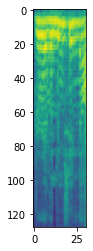

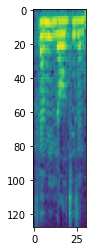

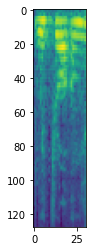

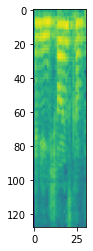

In [10]:
import matplotlib.pyplot as plt
import os
import random

from utils.files.save import load_torch


root = 'processed_data'
path = 'train/M011/contempt/level_2/melspec'
samples = 4
files = [file for file in os.listdir(os.path.join(root, path))]
ids = random.sample(range(0, len(files)), samples)
spec = load_torch(os.path.join(path, files[0]))
for id in ids:
    spec = load_torch(os.path.join(path, files[id]))
    plt.figure()
    plt.imshow(spec.log2().numpy())

In [11]:
def _convert_to_mono(signal: torch.Tensor) -> torch.Tensor:
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

def _check_for_resample(signal: torch.Tensor, original_sr: int, target_sample_rate: int) -> torch.Tensor:
    if original_sr != target_sample_rate:
        resampler = T.Resample(original_sr, target_sample_rate)
        signal = resampler(signal)
    return signal

def get_signal_mono(audio_path: str, config: dict) -> torch.Tensor:
    signal, sr = torchaudio.load(audio_path)
    signal = _check_for_resample(signal, sr, config['sample_rate'])
    return _convert_to_mono(signal)

def get_signal_mono2(audio_path: str, config: dict) -> torch.Tensor:
    signal, sr = torchaudio.load(audio_path)
    signal = _convert_to_mono(signal)
    return _check_for_resample(signal, sr, config['sample_rate'])

In [12]:
audio_path = 'processed_data/test/M019/angry/level_2/audio/014.wav'
s1 = get_signal_mono(audio_path=audio_path, config=config['audio'])
s2 = get_signal_mono2(audio_path=audio_path, config=config['audio'])
print(s1.shape)
print(s2.shape)
print((s1==s2).all())

torch.Size([1, 48128])
torch.Size([1, 48128])
tensor(True)
